In [1]:
import os

import nltk
from nltk.corpus import webtext, stopwords, treebank
from nltk.lm.preprocessing import pad_both_ends
from nltk.stem import PorterStemmer, SnowballStemmer

from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report


import numpy as np
import pandas as pd

from collections import Counter

import matplotlib.pyplot as plt
from wordcloud import WordCloud

from joblib import load
from joblib import dump


In [2]:
nltk.download('webtext')

[nltk_data] Downloading package webtext to
[nltk_data]     C:\Users\Joan\AppData\Roaming\nltk_data...
[nltk_data]   Package webtext is already up-to-date!


True

In [3]:
text = webtext.raw('firefox.txt')
tokens = nltk.word_tokenize(text)
vocabulary = Counter(tokens)
print("Vocabulary size: ", len(vocabulary))

Vocabulary size:  9300


In [4]:
Porter = PorterStemmer()
snowball_stemmer = [Porter.stem(word) for word in tokens]
print("Porter Stemmer vocabulary size: ", set(snowball_stemmer).__len__())

Snowball = SnowballStemmer("english")
snowball_stemmer = [Snowball.stem(word) for word in tokens]
print("Snowball Stemmer vocabulary size: ", set(snowball_stemmer).__len__())

Porter Stemmer vocabulary size:  5847
Snowball Stemmer vocabulary size:  5702


In [5]:
stopwords = stopwords.words('english')

In [6]:
vocab_stopwords = set(word for word in tokens if not word in stopwords)
print("The len of the vocabulary without stopwords is: ", len(vocab_stopwords))

The len of the vocabulary without stopwords is:  9187


In [7]:
own_stopowrds = stopwords
own_stopowrds.append('I')
vocab_stopwords_own = set(word for word in tokens if not word in own_stopowrds)
print("The len of the vocabulary without stopwords is: ", len(vocab_stopwords_own))

The len of the vocabulary without stopwords is:  9186


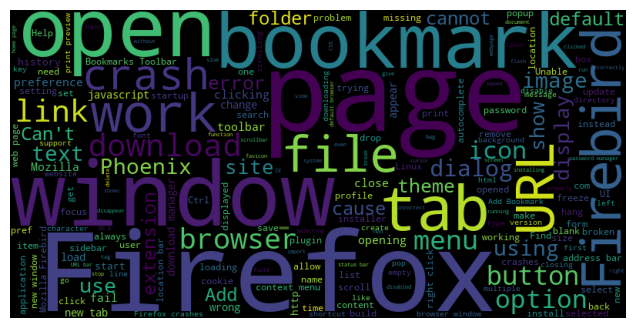

In [8]:
def generate_wordcloud(text):
    wordcloud = WordCloud(width=800, height=400,
                          relative_scaling = 1.0,
                          stopwords = stopwords,
                          ).generate(text)
    
    fig = plt.figure(1, figsize=(8, 4))
    plt.axis('off')
    plt.imshow(wordcloud)
    plt.savefig("WordCloud.png")

generate_wordcloud(text)

In [9]:
# Define the ufeatures() class
def ufeatures(utt, idx):
    ftdist = {}
    ftdist['word'] = utt[idx]
    ftdist['dist_from_first'] = idx - 0
    ftdist['dist_from_last'] = len(utt) - idx
    ftdist['capitalized'] = utt[idx][0].upper() == utt[idx][0]
    ftdist['prefix1'] = utt[idx][0]
    ftdist['prefix2'] = utt[idx][:2]
    ftdist['prefix3'] = utt[idx][:3]
    ftdist['suffix1'] = utt[idx][-1]
    ftdist['suffix2'] = utt[idx][-2:]
    ftdist['suffix3'] = utt[idx][-3:]
    ftdist['prev_word'] = '' if idx==0 else utt[idx-1]
    ftdist['next_word'] = '' if idx==(len(utt)-1) else utt[idx+1]
    ftdist['numeric'] = utt[idx].isdigit()
    return ftdist

In [39]:
#word2idx = {w: i for i, w in enumerate(set(treebank.words()) | {'<s>', '>', '<', '</s>'})}
#abece = set(i for i in " ".join(treebank.words()))
#char2idx = {c: i for i, c in enumerate(abece)}

sent_trebank = treebank.sents()
def obtain_feat(sents):
    features = []
    for sent in sents:
        added_begi_end = ['<s>'] + sent +['</s>']
        features.extend([ufeatures(added_begi_end, i) for i in range(len(added_begi_end))])
    return features

features = obtain_feat(sent_trebank)


In [11]:
Y_ground_truth_str = []
for sent in treebank.tagged_sents():
    sent_classes = [i[1] for i in sent]
    new_sent = ['<s>'] + sent_classes + ['</s>']
    Y_ground_truth_str.extend(new_sent)

In [12]:
class2idx = {c: i for i, c in enumerate(set(Y_ground_truth_str))}
idx2class = {i: c for i, c in enumerate(set(Y_ground_truth_str))}
Y_ground_truth = [class2idx[i] for i in Y_ground_truth_str]

In [13]:
X_train, X_test, Y_train, Y_test = train_test_split(features, Y_ground_truth, 
                                                    test_size=0.2, 
                                                    random_state=42)

In [14]:
vec = DictVectorizer(sparse=True)
X_train_matrix = vec.fit_transform(X_train)
X_test_matrix = vec.transform(X_test)

In [15]:
def retrive_model(joblib_file = None):
    if joblib_file and os.path.exists(joblib_file):
        model = load(joblib_file)
    else:
        model = RandomForestClassifier(n_estimators=100, random_state=42)
    return model

joblib_file = "random_forest_model.joblib"
model = retrive_model(joblib_file = joblib_file)

In [17]:
# Train if necessary
# Using grid search to find the best parameters
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 50, 100]
}

grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, n_jobs=12, verbose=10)
grid_search.fit(X_train_matrix, Y_train)

print("The best parameters are: ", grid_search.best_params_)
model = grid_search.best_estimator_

Fitting 5 folds for each of 12 candidates, totalling 60 fits


c:\Users\Joan\anaconda3\envs\DeepLearning\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


The best parameters are:  {'max_depth': None, 'n_estimators': 100}


In [28]:
# Using grid search to find the best parameters
param_grid = {
    'n_estimators': [80, 85, 90, 95, 100, 105, 110, 115, 120],
    'max_depth': [None]
}

grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, n_jobs=12, verbose=10)
grid_search.fit(X_train_matrix, Y_train)

print("The best parameters are: ", grid_search.best_params_)
model = grid_search.best_estimator_

Fitting 5 folds for each of 9 candidates, totalling 45 fits


c:\Users\Joan\anaconda3\envs\DeepLearning\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


The best parameters are:  {'max_depth': None, 'n_estimators': 100}


In [36]:
# Save the model
dump(model, joblib_file)


['random_forest_model.joblib']

In [30]:
# Predict the test set
Y_pred = model.predict(X_test_matrix)
# Import the evaluator

# Removing the <s> and </s> tags on the evaluation
to_remove = []
for i in range(len(Y_test)):
    if idx2class[Y_test[i]] == '<s>' or idx2class[Y_test[i]] == '</s>':
        to_remove.append(i)

Y_pred2 = [Y_pred[i] for i in range(len(Y_pred)) if i not in to_remove]
Y_test2 = [Y_test[i] for i in range(len(Y_test)) if i not in to_remove]

report = classification_report(Y_test2, 
                               Y_pred2, 
                               target_names=[idx2class[i] for i in set(Y_test2)],
                               zero_division=0)
print(report)

              precision    recall  f1-score   support

          IN       0.96      0.99      0.98      2054
      -NONE-       1.00      1.00      1.00      1328
          DT       1.00      0.99      0.99      1612
          RB       0.95      0.87      0.91       558
          CD       0.98      0.99      0.98       664
         NNS       0.93      0.98      0.96      1155
          LS       1.00      0.25      0.40         4
         VBG       0.87      0.94      0.90       306
         PDT       0.60      0.43      0.50         7
           ,       1.00      1.00      1.00      1005
         RBS       0.50      0.60      0.55         5
          CC       0.99      0.99      0.99       455
          TO       1.00      1.00      1.00       436
         VBP       0.89      0.67      0.76       290
         VBD       0.90      0.90      0.90       582
          EX       0.84      1.00      0.91        16
          VB       0.86      0.85      0.86       527
          NN       0.90    

In [31]:
# Make some predictions
def predict_sent(sent, model, vec, idx2class):
    sent = ['<s>'] + sent + ['</s>']
    features = [ufeatures(sent, i) for i in range(len(sent))]
    feature_matrix = vec.transform(features)
    Y_pred = model.predict(feature_matrix)
    return [idx2class[i] for i in Y_pred]

# Generate 5 sentences and predict the POS
sent = ["The dog is barking at the mailman", 
        "The cat is sleeping", 
        "The bird is flying", 
        "The fish is swimming", 
        "The horse is running"]
for s in sent:
    print(predict_sent(nltk.tokenize.word_tokenize(s), model, vec, idx2class))


['<s>', 'DT', 'NN', 'VBZ', 'VBG', 'IN', 'DT', 'NN', '</s>']
['<s>', 'DT', 'NN', 'VBZ', 'VBG', '</s>']
['<s>', 'DT', 'NN', 'VBZ', 'VBG', '</s>']
['<s>', 'DT', 'JJ', 'VBZ', 'VBG', '</s>']
['<s>', 'DT', 'NN', 'VBZ', 'VBG', '</s>']


In [32]:
sent2 = ["The quick brown fox jumps over the lazy dog",
        "She danced gracefully under the moonlit sky",
        "After a long day at work, he finally collapsed onto his bed",
        "The old oak tree stood tall and majestic in the middle of the meadow",
        "As the rain poured down, they huddled together under the umbrella for shelter"]
        

In [33]:
nltk.download('averaged_perceptron_tagger')
from nltk import pos_tag

for s in sent2:
    print(pos_tag(nltk.tokenize.word_tokenize(s)))

[('The', 'DT'), ('quick', 'JJ'), ('brown', 'NN'), ('fox', 'NN'), ('jumps', 'VBZ'), ('over', 'IN'), ('the', 'DT'), ('lazy', 'JJ'), ('dog', 'NN')]
[('She', 'PRP'), ('danced', 'VBD'), ('gracefully', 'RB'), ('under', 'IN'), ('the', 'DT'), ('moonlit', 'NN'), ('sky', 'NN')]
[('After', 'IN'), ('a', 'DT'), ('long', 'JJ'), ('day', 'NN'), ('at', 'IN'), ('work', 'NN'), (',', ','), ('he', 'PRP'), ('finally', 'RB'), ('collapsed', 'VBD'), ('onto', 'IN'), ('his', 'PRP$'), ('bed', 'NN')]
[('The', 'DT'), ('old', 'JJ'), ('oak', 'NN'), ('tree', 'NN'), ('stood', 'VBD'), ('tall', 'JJ'), ('and', 'CC'), ('majestic', 'JJ'), ('in', 'IN'), ('the', 'DT'), ('middle', 'NN'), ('of', 'IN'), ('the', 'DT'), ('meadow', 'NN')]
[('As', 'IN'), ('the', 'DT'), ('rain', 'NN'), ('poured', 'VBD'), ('down', 'RB'), (',', ','), ('they', 'PRP'), ('huddled', 'VBD'), ('together', 'RB'), ('under', 'IN'), ('the', 'DT'), ('umbrella', 'NN'), ('for', 'IN'), ('shelter', 'NN')]


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Joan\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


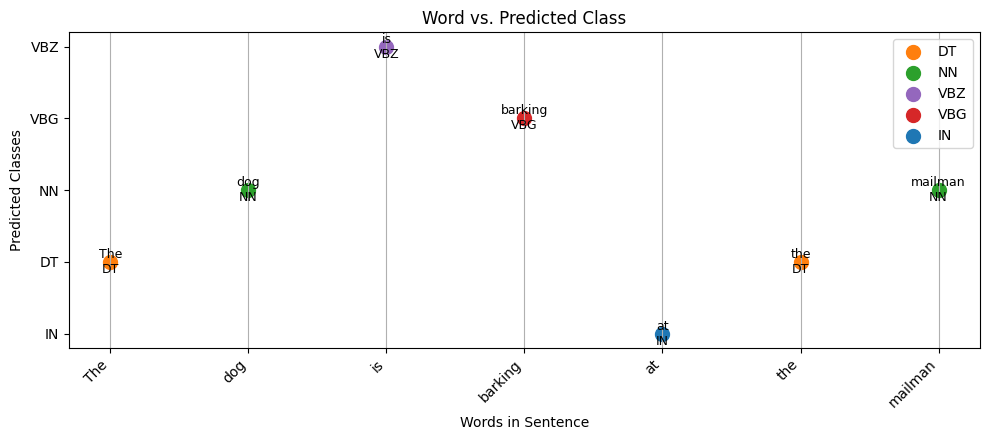

In [34]:
def visualize_predictions(sent, predictions):
    # Remove the padding from the predictions
    predictions = predictions[1:-1]
    

    # Setting up the plot
    plt.figure(figsize=(10, 4.5))  # Increase the figure size for better readability
    plt.yticks(range(len(set(predictions))), list(set(predictions)))  # Set the y-ticks to the unique classes
    plt.xticks(range(len(sent)), sent, rotation=45, ha="right")  # Rotate x labels for better visibility

    # Colormap so each class has a different color
    cmap = plt.get_cmap('tab10')
    label2idx = {label: i for i, label in enumerate(set(predictions))}
    
    # Create a scatter plot with a point for each word-prediction pair
    for i, (word, pred) in enumerate(zip(sent, predictions)):
        plt.scatter(i, list(set(predictions)).index(pred), s=100, label=pred, color=cmap(label2idx[pred]))
        # Move the text down a bit for better visibility
        plt.text(i, list(set(predictions)).index(pred), f'{word}\n{pred}', fontsize=9,
                 ha='center', va='center')

    # Adding details
    plt.title('Word vs. Predicted Class')
    plt.xlabel('Words in Sentence')
    plt.ylabel('Predicted Classes')
    plt.grid(axis='x')

    # Show legend and plot
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))  # Remove duplicates in legend
    plt.legend(by_label.values(), by_label.keys())
    plt.tight_layout()
    plt.show()

# Example usage with your function
# Assuming 'model', 'vec', and 'idx2class' are already defined and initialized
sentence = nltk.tokenize.word_tokenize(sent[0])
predictions = predict_sent(sentence, model, vec, idx2class)
visualize_predictions(sentence, predictions)


### Feature importance

In [40]:
list_features_original = features[0].keys()
print("The original features are: ", list_features_original)

# Obtain the range in the feature matrix for each feature
feature_ranges = {k:[] for k in list_features_original}
for i, name in enumerate(vec.get_feature_names_out()):
    feature_name = name.split('=')[0]
    feature_ranges[feature_name].append(i)

# Getting the min and max index for each feature
feature_ranges = {k: (min(v), max(v)) for k, v in feature_ranges.items()}
for k, v in feature_ranges.items():
    print(f"The range for the feature {k} is from {v[0]} to {v[1]}")

The original features are:  dict_keys(['word', 'dist_from_first', 'dist_from_last', 'capitalized', 'prefix1', 'prefix2', 'prefix3', 'suffix1', 'suffix2', 'suffix3', 'prev_word', 'next_word', 'numeric'])
The range for the feature word is from 29156 to 40174
The range for the feature dist_from_first is from 1 to 1
The range for the feature dist_from_last is from 2 to 2
The range for the feature capitalized is from 0 to 0
The range for the feature prefix1 is from 11101 to 11177
The range for the feature prefix2 is from 11178 to 11910
The range for the feature prefix3 is from 11911 to 15028
The range for the feature suffix1 is from 26045 to 26119
The range for the feature suffix2 is from 26120 to 26764
The range for the feature suffix3 is from 26765 to 29155
The range for the feature prev_word is from 15029 to 26044
The range for the feature next_word is from 3 to 11099
The range for the feature numeric is from 11100 to 11100


#### Using impurity-based importance

In [41]:
importances = model.feature_importances_
# Aggregating the feature importances of the same original feature by summing them
feature_importances_original = {k: 0 for k in list_features_original}
for k, v in feature_ranges.items():
    feature_importances_original[k] = np.sum(importances[v[0]:v[1]+1])

In [42]:
# Computing the standard deviation of the feature importances
feature_importances_trees = [tree.feature_importances_ for tree in model.estimators_]

feature_importances_std = {k: [] for k in list_features_original}
for k, v in feature_ranges.items():
    for tree_importances in feature_importances_trees:
        feature_importances_std[k].append(np.sum(tree_importances[v[0]:v[1]+1]))

feature_importances_std = {k: np.std(v) for k, v in feature_importances_std.items()}

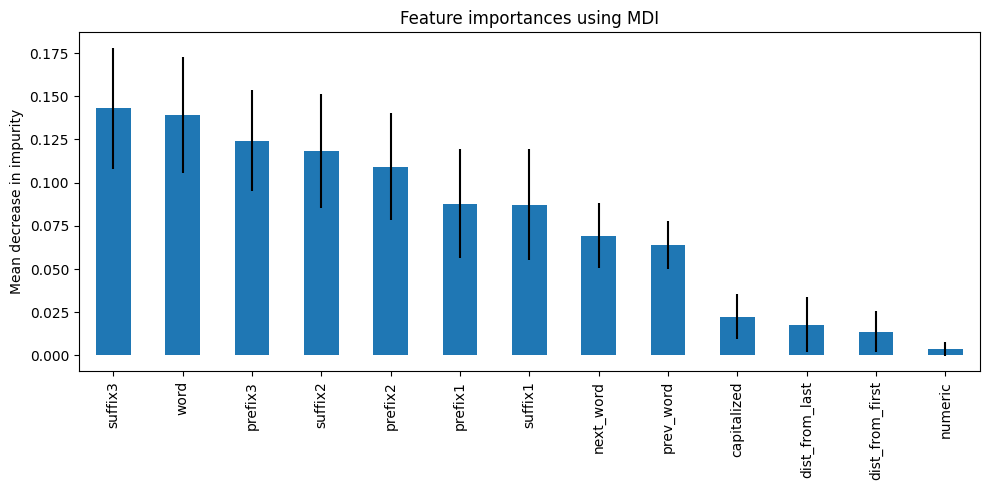

In [43]:
# Sorting the feature importances, from the most to the least important
sorted_importances = sorted(feature_importances_original.items(), key=lambda x: x[1], reverse=True)
features = [i[0] for i in sorted_importances]
importances = [i[1] for i in sorted_importances]

# Creating a pandas series for the feature importances, for better visualization
model_importances = pd.Series(importances, index=features)

fig, ax = plt.subplots(figsize=(10, 5))
model_importances.plot.bar(yerr=[feature_importances_std[feat] for feat in features], ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
plt.show()
